# Predicting Housing Prices (Ames, Iowa)

## Import neccesary Libraries

In [ ]:

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
pip install --upgrade xgboost

     |████████████████████████████████| 127.6 MB 10 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.0.2
    Uninstalling xgboost-1.0.2:
      Successfully uninstalled xgboost-1.0.2
Note: you may need to restart the kernel to use updated packages.


# Reading and Understanding Data

In [3]:
# Load the training and testing data
train = pd.read_csv("../input/home-data-for-ml-course/train.csv", index_col='Id')
test = pd.read_csv("../input/home-data-for-ml-course/test.csv", index_col='Id')

train_xy = train.copy()
# Separate the response variable from the predictor variables in the training data
#train_x = train.drop(['SalePrice'], axis=1)
#train_y = train['SalePrice'].copy()

# Since the testing data consist only of predictor variables, copy the data
test_x = test.copy()

In [4]:
# Look at first 5 rows of training data to understand the data
train_xy.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_xy.shape

(1460, 80)

In [6]:
test_x.shape

(1459, 79)

In [7]:
# Identify types and null counts to understand the data
train_xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [8]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearB

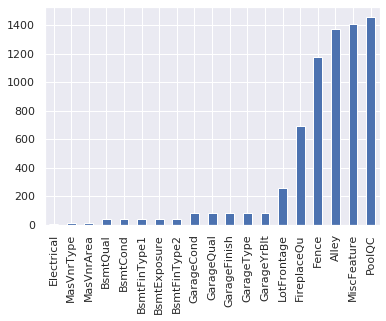

In [9]:
# Check missing values
missing_values = train_xy.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()

In [10]:
numerical_cols = train_xy.select_dtypes(exclude=['object']).drop(['SalePrice'], axis=1)
numerical_cols

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,460,0,40,0,0,0,0,0,8,2007
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,500,349,0,0,0,0,0,0,2,2010
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,252,0,60,0,0,0,0,2500,5,2010


In [11]:
categorical_cols = train_xy.select_dtypes(include=['object'])
categorical_cols

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal


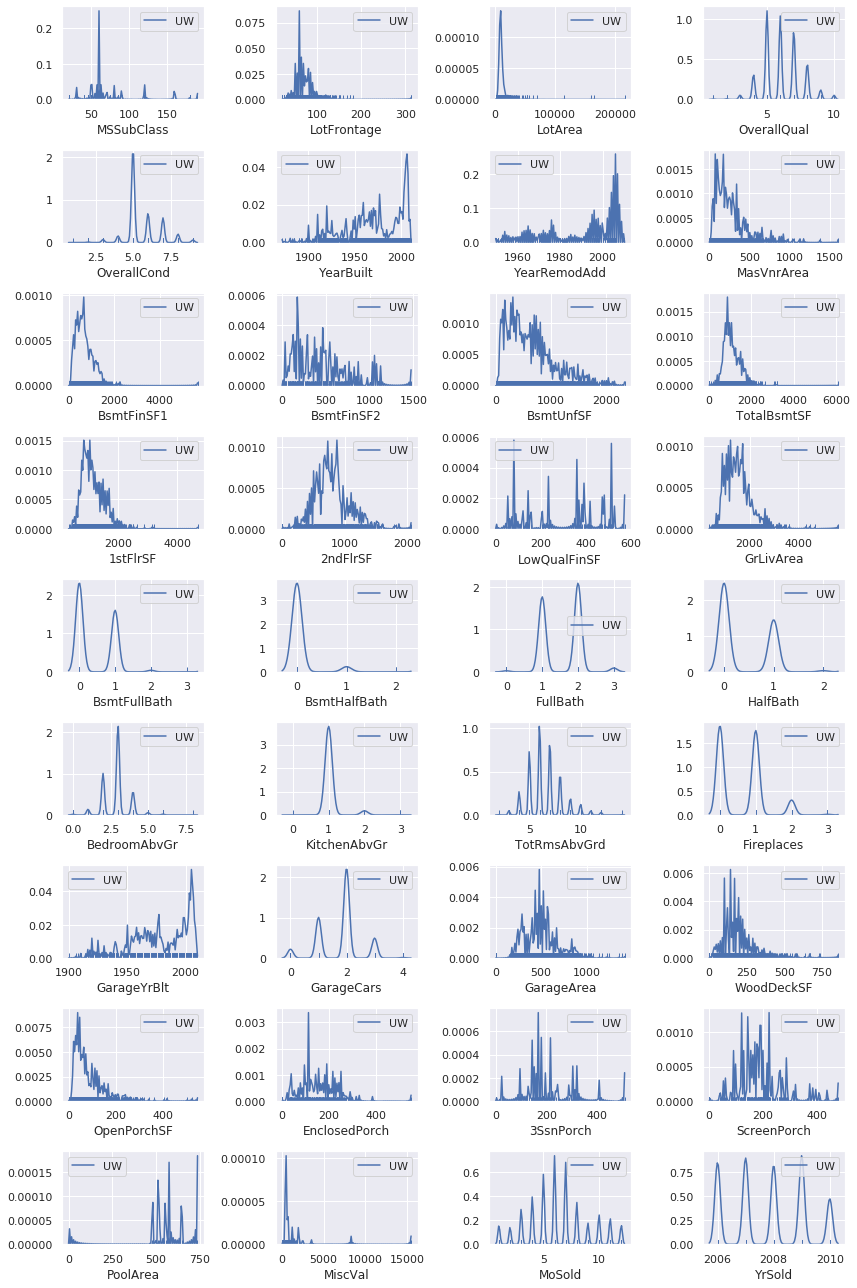

In [12]:
# Create ditribution plot to understand distribution of each numerical features
fig = plt.figure(figsize=(12,18))
for i in range(len(numerical_cols.columns)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(numerical_cols.iloc[:,i].dropna(), rug=True, hist=False, label='UW', kde_kws={'bw':0.1})
    plt.xlabel(numerical_cols.columns[i])
plt.tight_layout()
plt.show()

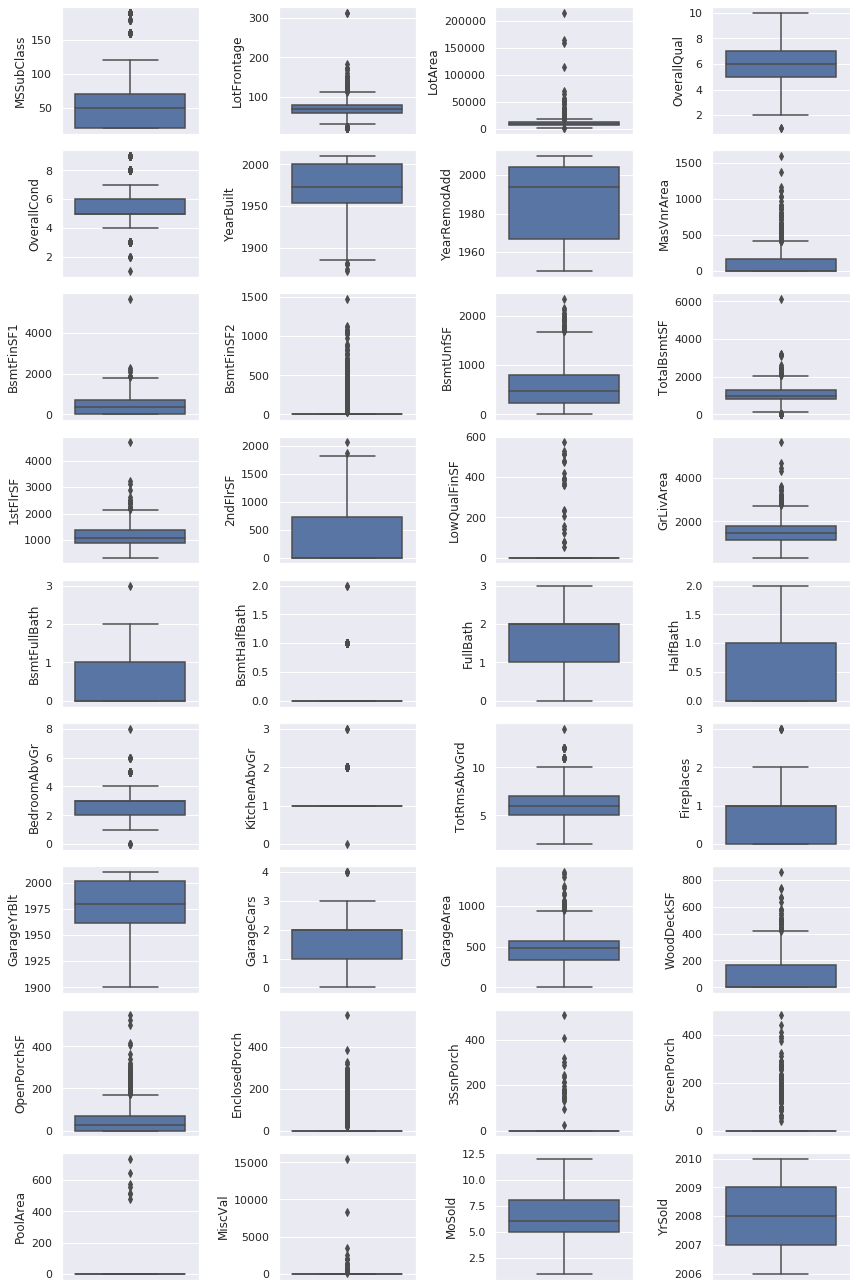

In [13]:
# Plot boxplots for univariate analysis
fig = plt.figure(figsize=(12,18))
for i in range(len(numerical_cols.columns)):
    fig.add_subplot(9,4,i+1)
    sns.boxplot(y=numerical_cols.iloc[:,i])

plt.tight_layout()
plt.show()

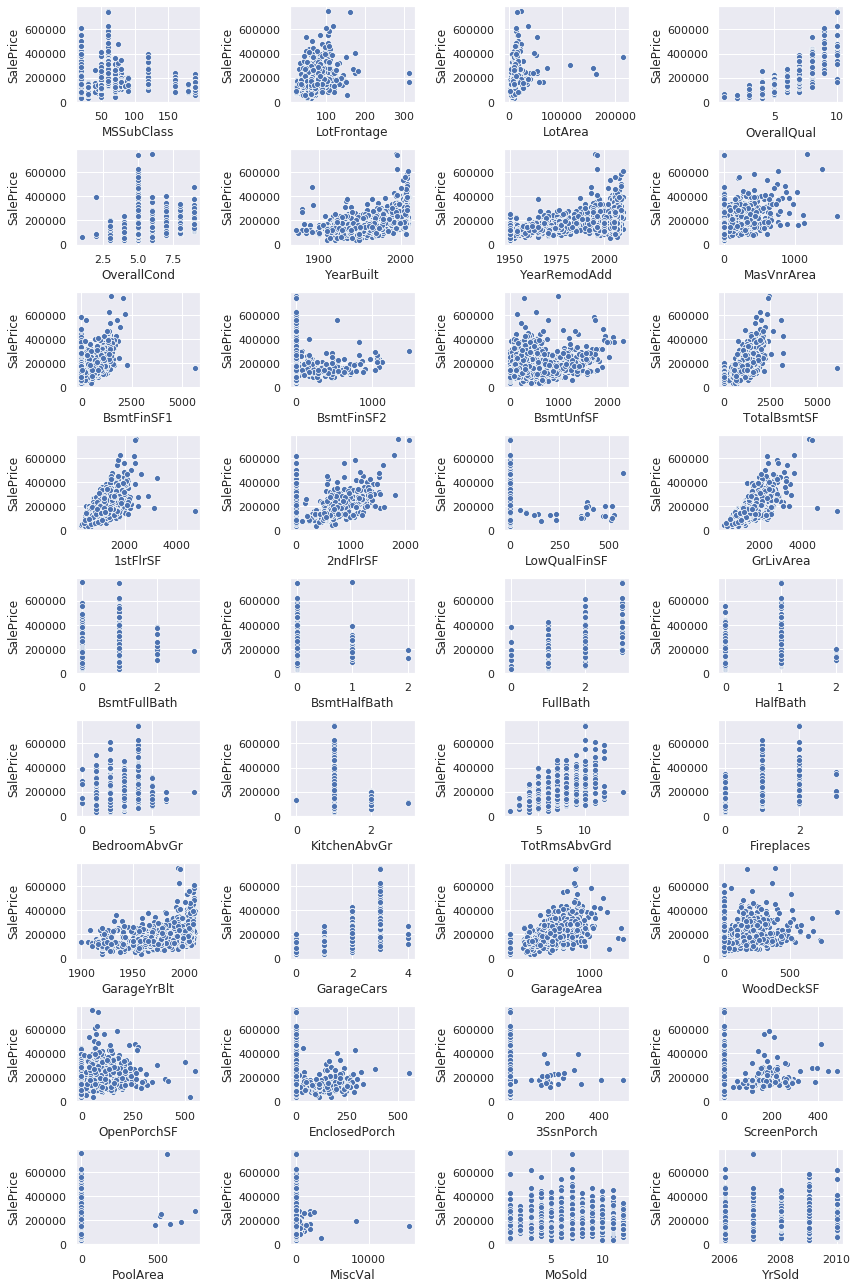

In [14]:
# Plot scatterplot for bivariate analysis
fig = plt.figure(figsize=(12,18))
for i in range(len(numerical_cols.columns)):
    fig.add_subplot(9, 4, i+1)
    sns.scatterplot(numerical_cols.iloc[:, i],train_xy['SalePrice'])
plt.tight_layout()
plt.show()

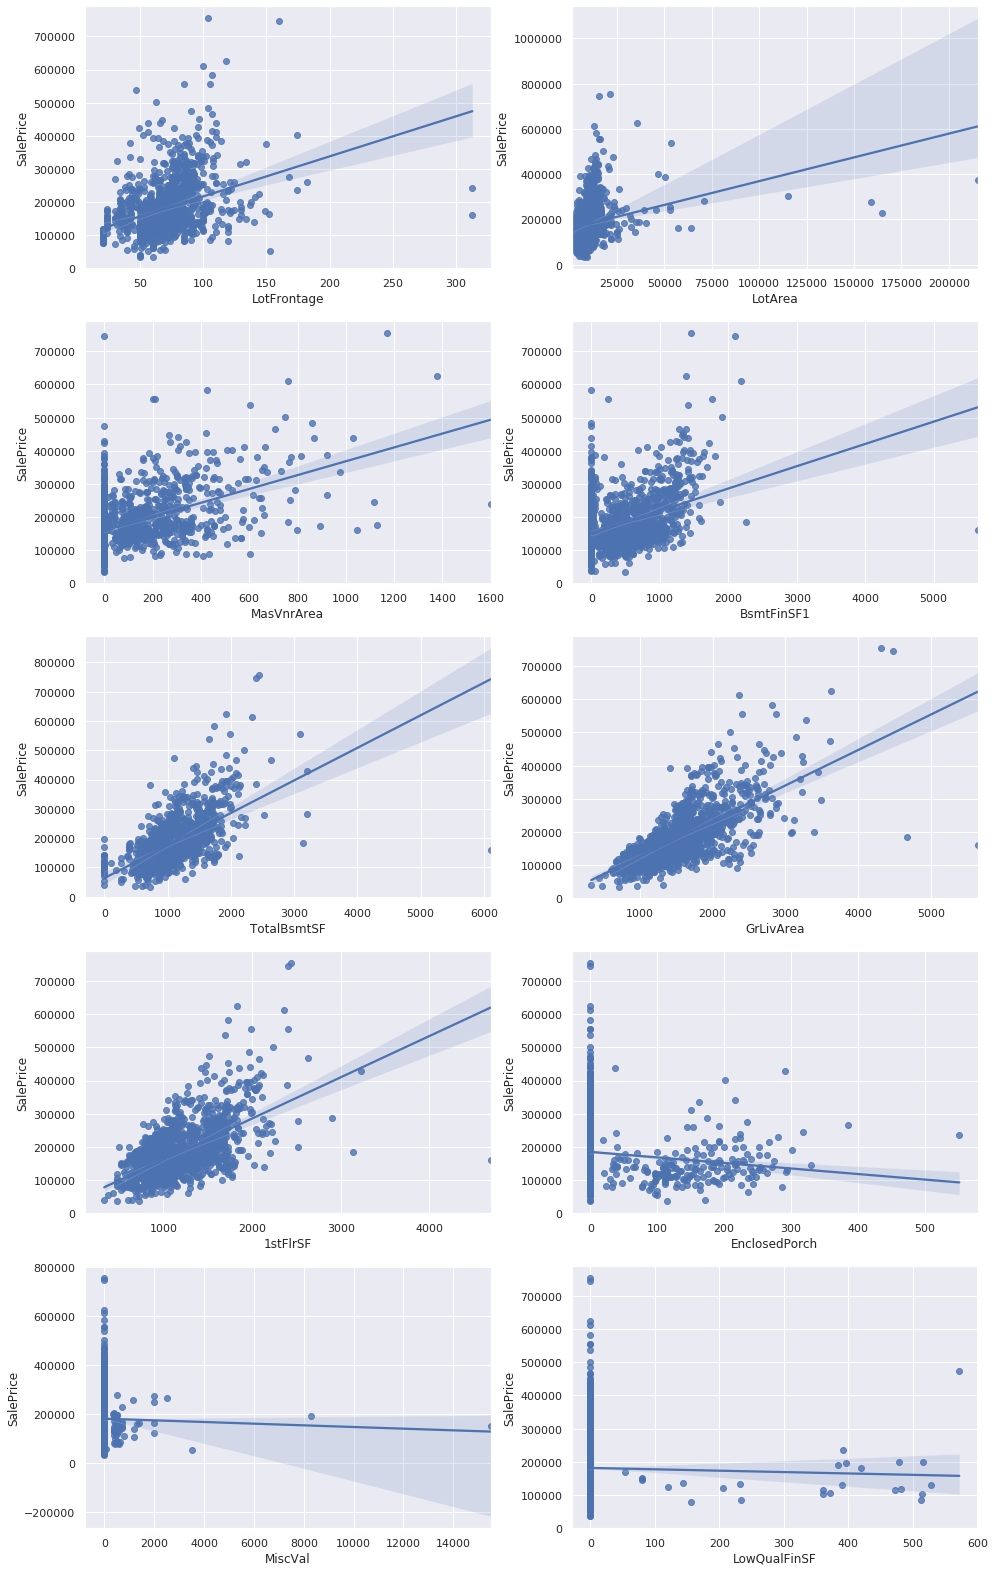

In [15]:
# Plot regression plots for variables with potential outliers identified by plots above
# Potential outeliers: LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, TotalBsmtSF, GrLivArea, 1stFlrSF
#                      EnclosedPorch, MiscVal, LowQualFinSF

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2)
figure.set_size_inches(16,28)
_ = sns.regplot(train_xy['LotFrontage'], train_xy['SalePrice'], ax=ax1)
_ = sns.regplot(train_xy['LotArea'], train_xy['SalePrice'], ax=ax2)
_ = sns.regplot(train_xy['MasVnrArea'], train_xy['SalePrice'], ax=ax3)
_ = sns.regplot(train_xy['BsmtFinSF1'], train_xy['SalePrice'], ax=ax4)
_ = sns.regplot(train_xy['TotalBsmtSF'], train_xy['SalePrice'], ax=ax5)
_ = sns.regplot(train_xy['GrLivArea'], train_xy['SalePrice'], ax=ax6)
_ = sns.regplot(train_xy['1stFlrSF'], train_xy['SalePrice'], ax=ax7)
_ = sns.regplot(train_xy['EnclosedPorch'], train_xy['SalePrice'], ax=ax8)
_ = sns.regplot(train_xy['MiscVal'], train_xy['SalePrice'], ax=ax9)
_ = sns.regplot(train_xy['LowQualFinSF'], train_xy['SalePrice'], ax=ax10)

In [16]:
# Remove outliers identified from plot above
train_xy = train_xy.drop(train_xy[train_xy['LotFrontage'] > 200].index)
train_xy = train_xy.drop(train_xy[train_xy['LotArea']>100000].index)
train_xy = train_xy.drop(train_xy[train_xy['MasVnrArea']>1200].index)
train_xy = train_xy.drop(train_xy[train_xy['BsmtFinSF1']>3000].index)
train_xy = train_xy.drop(train_xy[train_xy['TotalBsmtSF']>4000].index)
train_xy = train_xy.drop(train_xy[(train_xy['GrLivArea']>4000) & (train_xy['SalePrice']<200000)].index)
train_xy = train_xy.drop(train_xy[train_xy['1stFlrSF']>4000].index)
train_xy = train_xy.drop(train_xy[train_xy['EnclosedPorch']>500].index)
train_xy = train_xy.drop(train_xy[train_xy['MiscVal']>4000].index)
train_xy = train_xy.drop(train_xy[(train_xy['LowQualFinSF']>550) & (train_xy['SalePrice']>400000)].index)

In [17]:
train_xy.shape

(1447, 80)

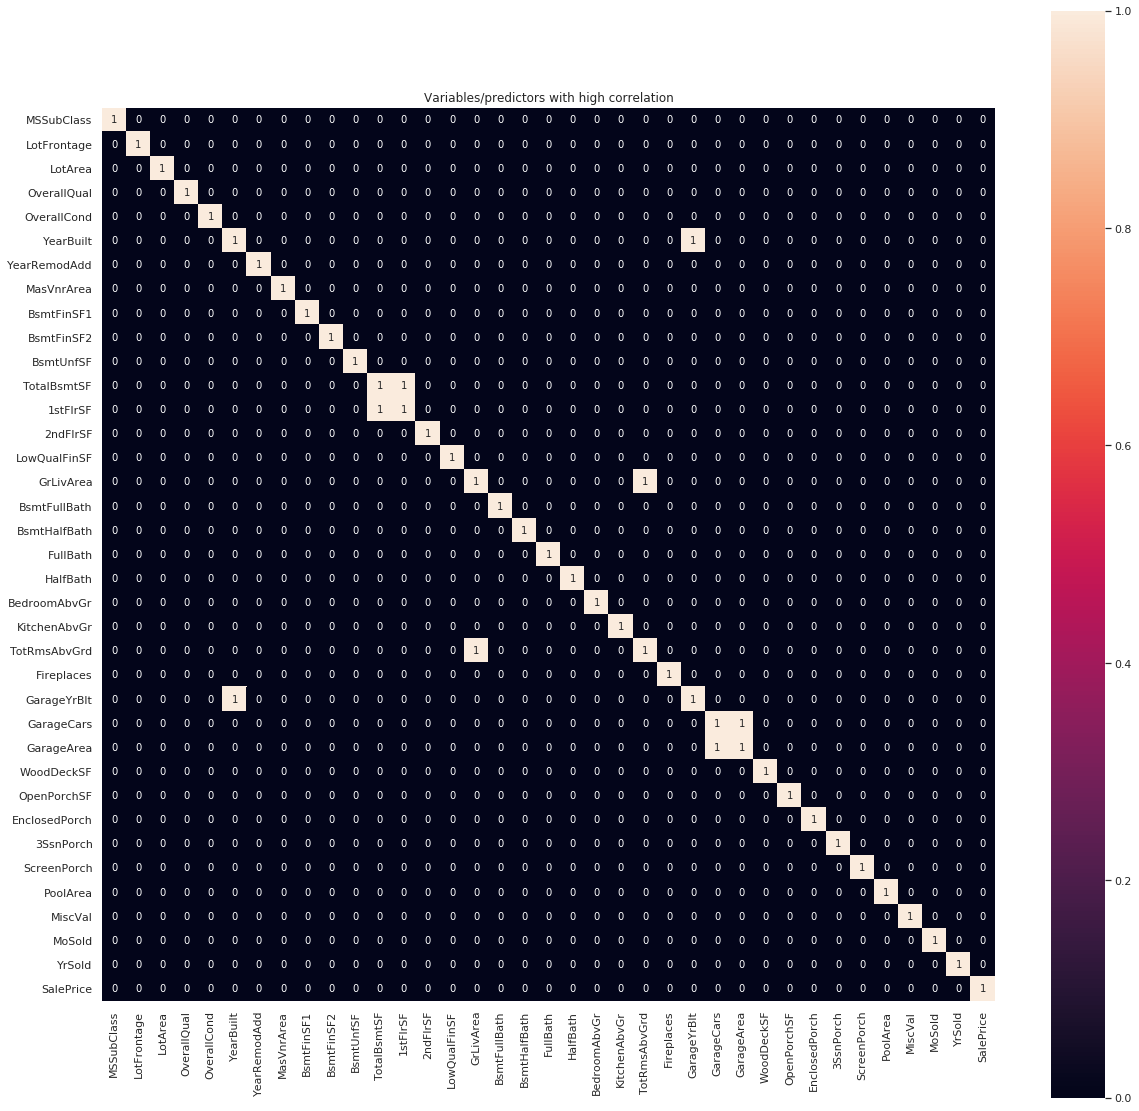

In [18]:
# Find highly correlated variables to prevent multicolinearity
corr_matrix = train_xy.select_dtypes(exclude='object').corr()
plt.figure(figsize=(20,20))
plt.title('Variables/predictors with high correlation')
sns.heatmap(corr_matrix >= 0.8, annot=True, square=True)

In [19]:
# Determing correlation of each predictors with the response variable
corr = corr_matrix.corr()
print(corr['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.955678
GarageCars       0.904219
GarageArea       0.897161
TotalBsmtSF      0.826072
1stFlrSF         0.804196
GrLivArea        0.796546
FullBath         0.796280
MasVnrArea       0.794653
YearBuilt        0.792445
YearRemodAdd     0.755851
GarageYrBlt      0.754114
Fireplaces       0.719264
TotRmsAbvGrd     0.617086
LotFrontage      0.600330
OpenPorchSF      0.577970
WoodDeckSF       0.573756
LotArea          0.522992
BsmtFinSF1       0.497931
BsmtUnfSF        0.441086
HalfBath         0.385872
BsmtFullBath     0.276182
2ndFlrSF         0.243810
BedroomAbvGr     0.175940
ScreenPorch      0.001785
PoolArea        -0.013864
MoSold          -0.029382
3SsnPorch       -0.040588
YrSold          -0.213635
BsmtFinSF2      -0.221821
BsmtHalfBath    -0.236504
MSSubClass      -0.280286
LowQualFinSF    -0.310204
MiscVal         -0.348109
KitchenAbvGr    -0.365868
EnclosedPorch   -0.480553
OverallCond     -0.485585
Name: SalePrice, dtype: float64


In [20]:
# For each autocorrelated features, drop the features that is less correlated with the response variable
train_xy.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True) 
test_x.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True)

In [21]:
# Check proportion of missing values in each predictor in training data set
train_xy.isnull().mean().sort_values(ascending=False).head(10)

PoolQC          0.996545
MiscFeature     0.965446
Alley           0.937802
Fence           0.807187
FireplaceQu     0.476158
LotFrontage     0.175536
GarageCond      0.055978
GarageType      0.055978
GarageFinish    0.055978
GarageQual      0.055978
dtype: float64

In [22]:
#  Drop predictors with >80% of missing values
train_xy.drop(columns=['Alley','MiscFeature','PoolQC','PoolArea', 'Fence'], axis=1, inplace=True)
test_x.drop(columns=['Alley','MiscFeature','PoolQC','PoolArea', 'Fence'], axis=1, inplace=True)

In [23]:
# Check proportion of missing values in each predictor in testing data set
test_x.isnull().mean().sort_values(ascending=False).head(10)

FireplaceQu     0.500343
LotFrontage     0.155586
GarageQual      0.053461
GarageCond      0.053461
GarageFinish    0.053461
GarageType      0.052090
BsmtCond        0.030843
BsmtQual        0.030158
BsmtExposure    0.030158
BsmtFinType1    0.028787
dtype: float64

Since proportion of missing values in testing data <80%, do not drop any columns

# Filling in Missing values in Numerical Predictors

In [24]:
# Determing proportion of missing values in training and testing data set
train_xy_numerical_null = train_xy.select_dtypes(exclude='object').isnull().mean()
test_x_numerical_null = test_x.select_dtypes(exclude='object').isnull().mean()

train_test_numerical_null = pd.DataFrame(data = {'Missing numerical train_xy percentage:  ':
                                                 train_xy_numerical_null[train_xy_numerical_null>0],
                                      'Missing numerical test_x percentage: ':
                                                 test_x_numerical_null[test_x_numerical_null>0]})
train_test_numerical_null.index.name = 'Numerical Predictors'

train_test_numerical_null

,Missing numerical train_xy percentage:,Missing numerical test_x percentage:
Numerical Predictors,,
BsmtFinSF1,NaN,0.000685
BsmtFinSF2,NaN,0.000685
BsmtFullBath,NaN,0.001371
BsmtHalfBath,NaN,0.001371
BsmtUnfSF,NaN,0.000685
GarageCars,NaN,0.000685
LotFrontage,0.175536,0.155586
MasVnrArea,0.005529,0.010281
TotalBsmtSF,NaN,0.000685


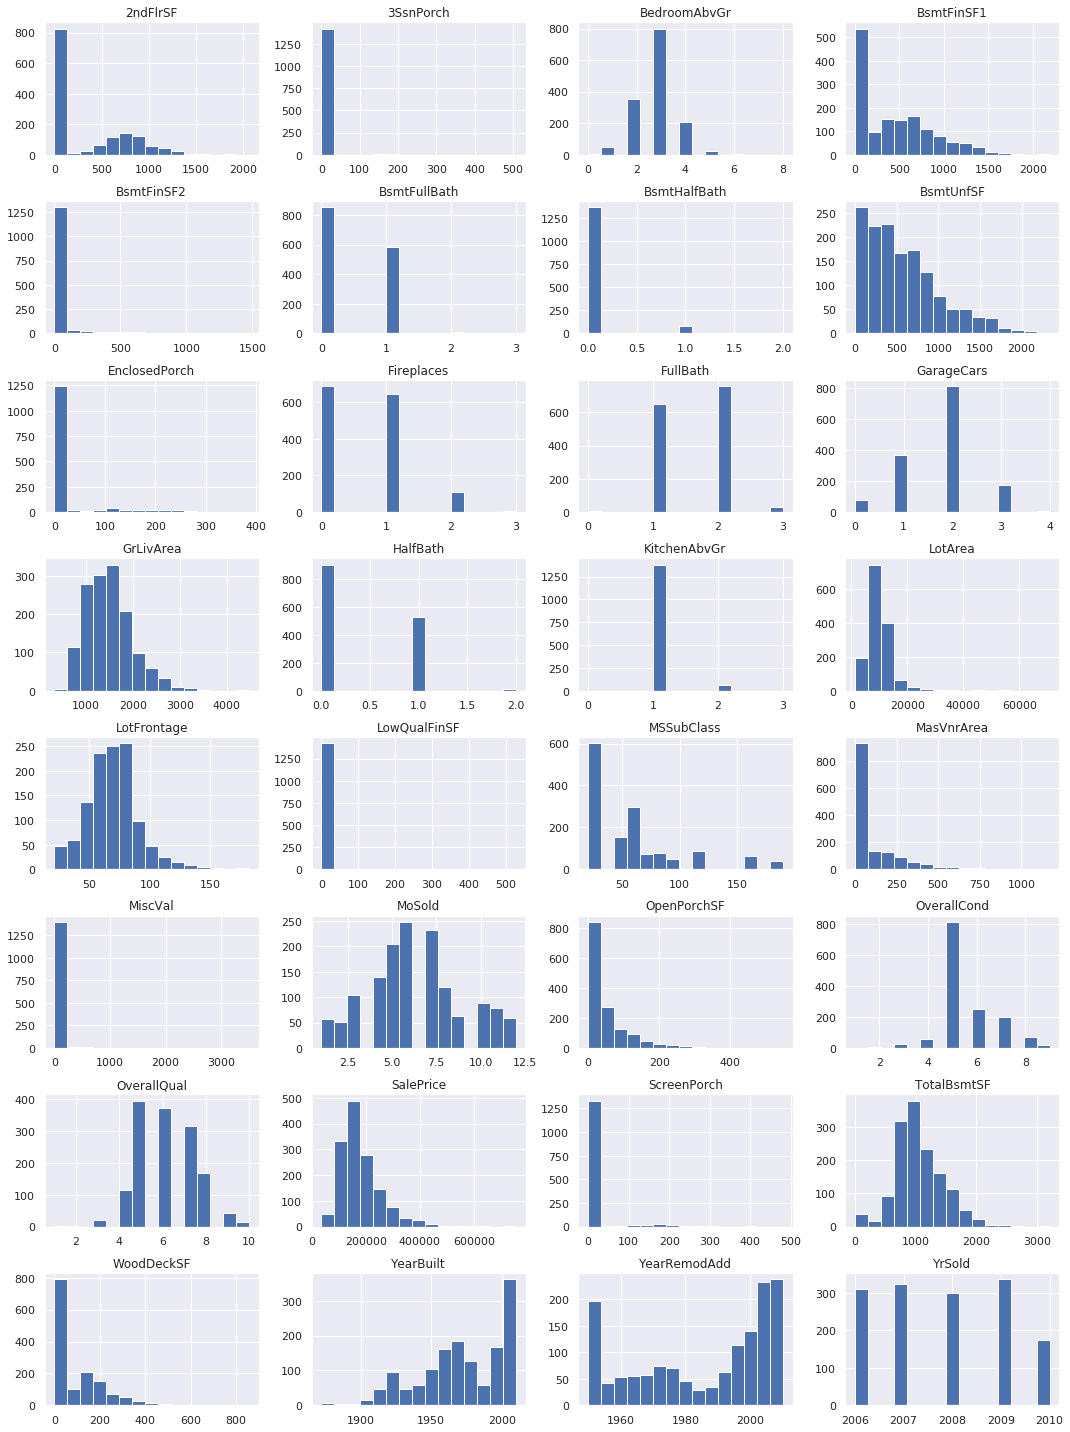

In [25]:
# Plot histogram for all numerical features to determine its distribution
train_xy_numerical_cols = train_xy.select_dtypes(exclude='object').columns
train_xy[train_xy_numerical_cols].hist(bins=15, figsize=(15, 20), layout=(8,4))
plt.tight_layout()

In [26]:
# Impute missing values in numerical features with the median as most are not normally distributed/ are skewed
for df in [train_xy, test_x]:
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageCars',
               'LotFrontage', 'MasVnrArea', 'TotalBsmtSF'):
        df[col] = df[col].fillna(df[col].median())

In [27]:
cat_col = train_xy.select_dtypes(include='object').columns
len(cat_col)

39

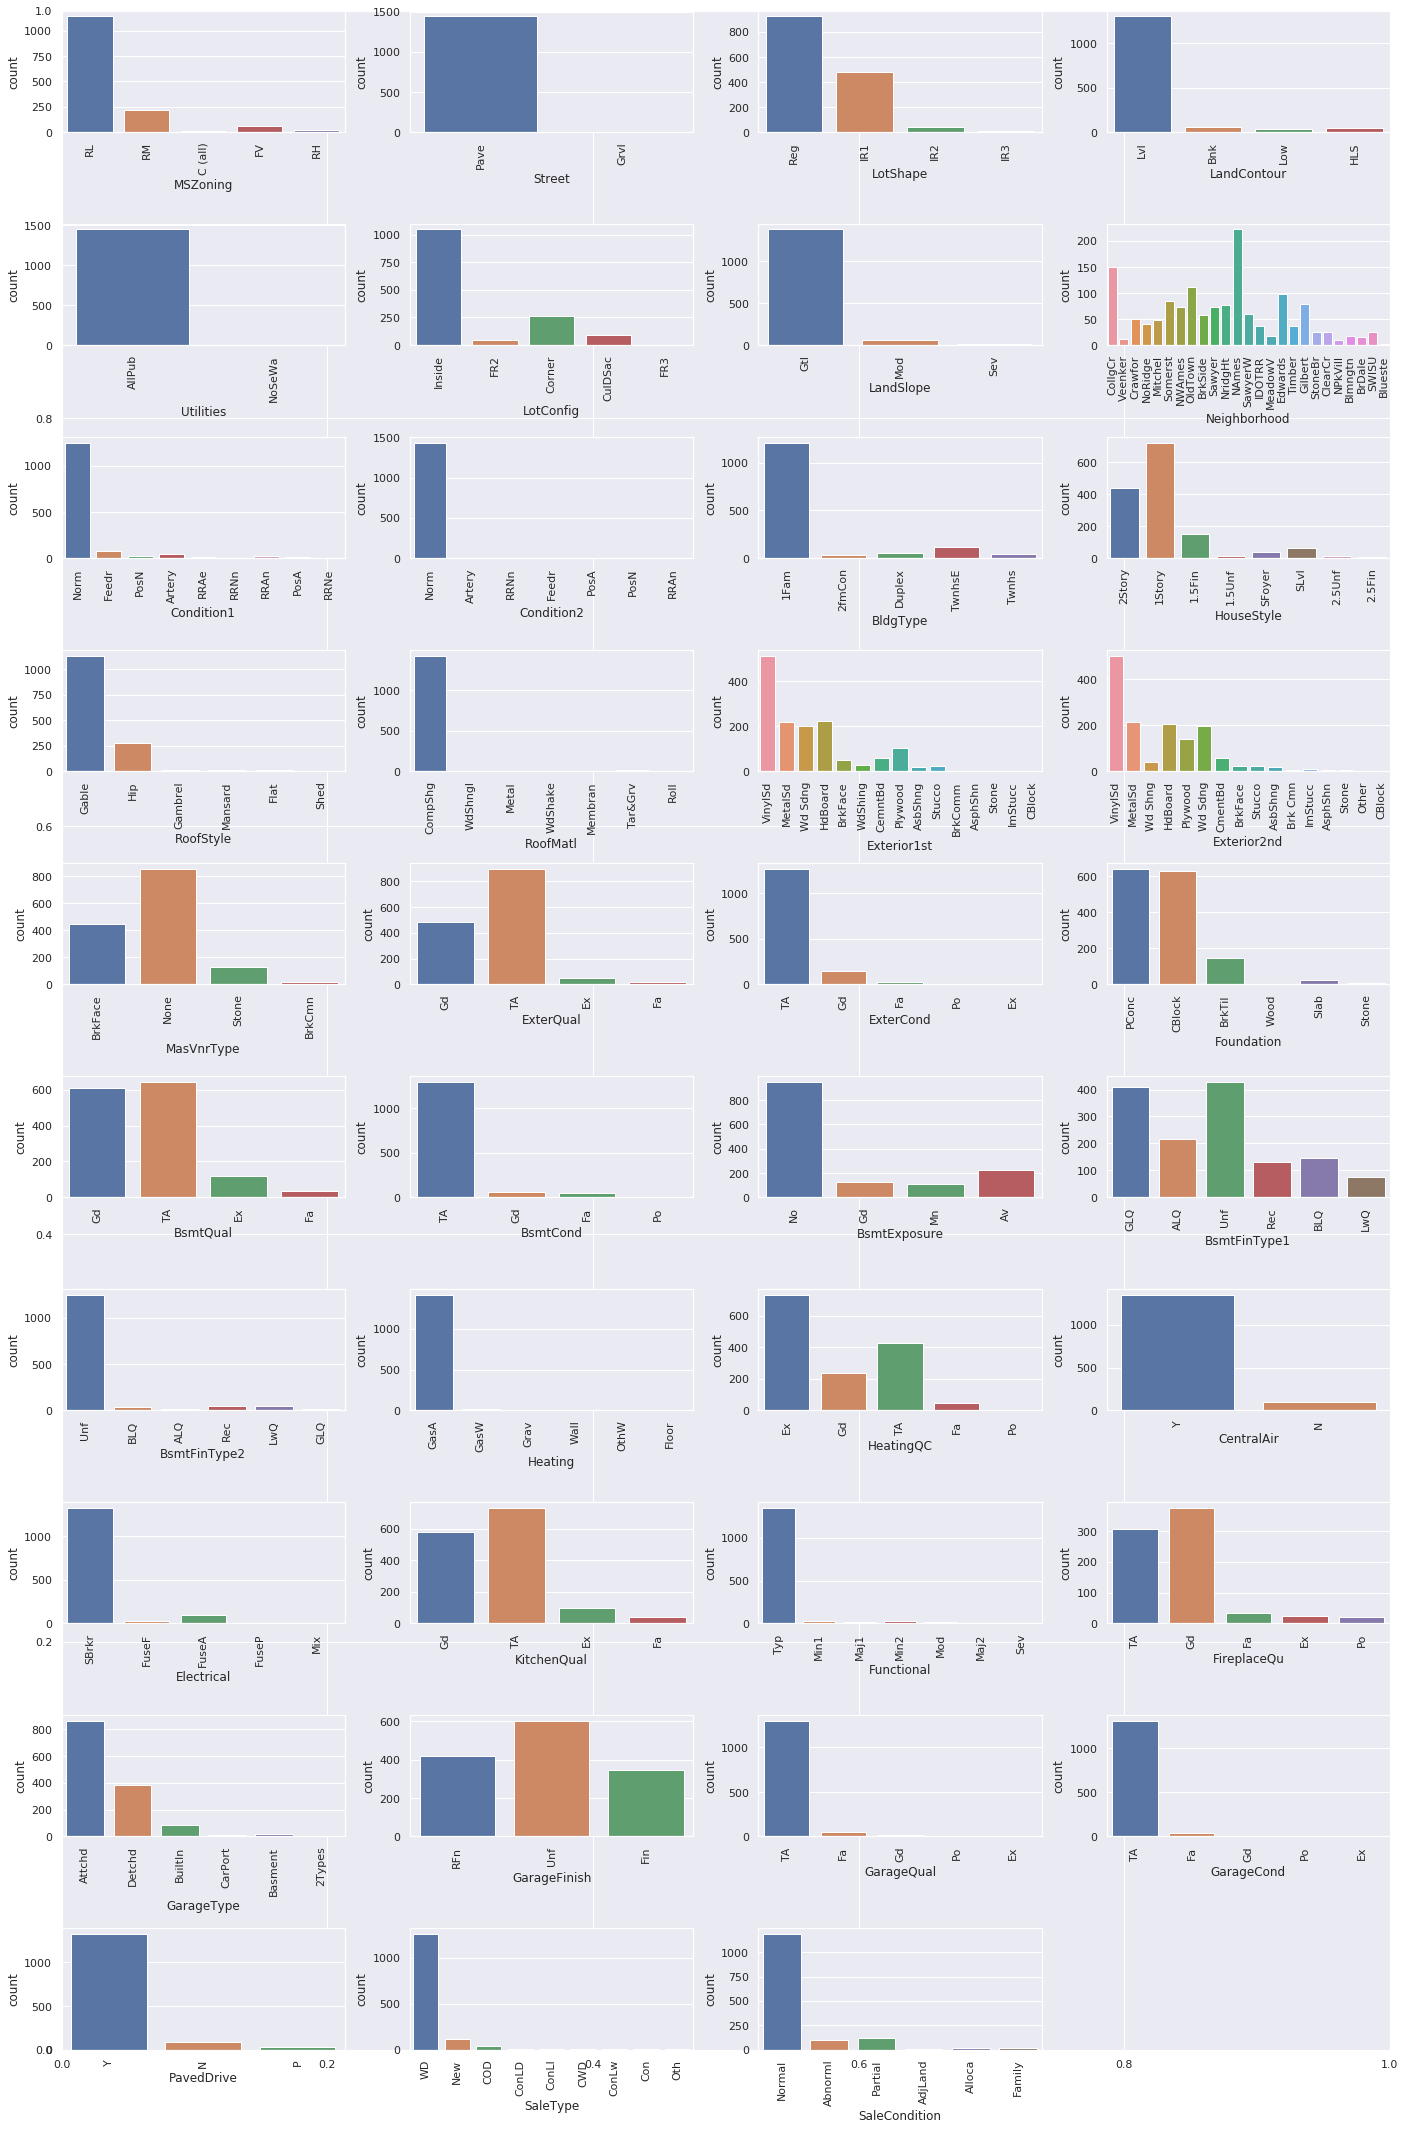

In [28]:
# Plot countplot for all categorical features to determine its distribution
fg, ax = plt.subplots(figsize=(20, 30))

for i, col in enumerate(cat_col):
    fg.add_subplot(10, 4, i+1)
    sns.countplot(train_xy[col])
    plt.xlabel(col)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [29]:
# Impute the mode for missing values in each categorical features as most were not normally distributed
for col in train_xy.select_dtypes(include='object'):
    train_xy[col]=train_xy[col].fillna(train_xy[col].mode()[0])

for col in test_x.select_dtypes(include='object'):
    test_x[col]=test_x[col].fillna(test_x[col].mode()[0])

# Modelling

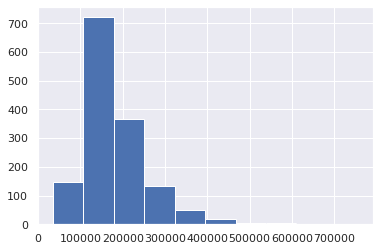

In [30]:
train_xy['SalePrice'].hist()

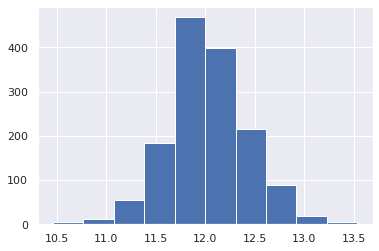

In [31]:
# log transform the reponse variable as it is skewed
np.log1p(train_xy['SalePrice']).hist()

In [32]:
# separate predictor and response variable; log trasnform predictor as it was skewed
X = train_xy.drop(['SalePrice'], axis=1)
y = np.log1p(train_xy['SalePrice'])

In [33]:
y.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

In [34]:
# Split X and y into training and validation data (Cross-validation) for model testing
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=2)

In [35]:
test_x.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,140,0,0,0,120,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,393,36,0,0,0,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,212,34,0,0,0,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,360,36,0,0,0,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0,82,0,0,144,0,1,2010,WD,Normal


In [36]:
# Separate categorical and numerical columns for Pipeline process; select categorical variables <30 unique values
# to avoid creation of spars matrix/increasing data size
categorical_cols_X = [cname for cname in X.columns if
                    X[cname].nunique() <= 30 and
                    X[cname].dtype == "object"] 
                


numerical_cols_X = [cname for cname in X.columns if
                 X[cname].dtype in ['int64','float64']]

my_cols = numerical_cols_X + categorical_cols_X

X_train = X_train[my_cols].copy()
X_valid = X_valid[my_cols].copy()
X_test = test_x[my_cols].copy()

In [37]:
# Create Pipeline
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median'))
    ])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols_X),       
        ('cat',cat_transformer,categorical_cols_X),
        ])

In [38]:
# Function to reverse log-transform y 
def inv_y(transformed_y):
    return np.exp(transformed_y)

# Baseline model using XGBRegressor
baseline_model =XGBRegressor(booster='gbtree',learning_rate=0.05, early_stopping_rounds=200, n_estimators=999,
                     max_depth=5, min_child_weight=1,
                     gamma=0, subsample=0.8,
                     colsample_bytree=0.8,
                     objective='reg:squarederror', nthread=-1,
                     reg_alpha=0)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', baseline_model)])
    
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
score = mean_absolute_error(inv_y(y_valid), inv_y(preds))

print(f'Score: {score:.4f}')

Score: 14131.9362


## Hyperparameter Optimization using Randomized Search

In [39]:
model = XGBRegressor(n_estimators=999,early_stopping_rounds=200, reg_lambda=1, learning_rate=0.05, min_chid_weight=1, 
                     colsample_bytree=0.8, booster='gbtree', objective='reg:squarederror')

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model',model)])


# parameter space determined from Analytics Vidhya 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
params={
'model__max_depth':[3,5,7,9],
'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
'model__gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 
'model__reg_alpha': [1e-5, 1e-2, 0.1, 1.0, 100.0]
}

clf = RandomizedSearchCV(pipeline, params, cv=5, return_train_score=False, scoring= 'neg_mean_absolute_error')

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('num_imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                                 

In [40]:
print(clf.best_score_)
print(clf.best_params_)

-0.08634321184537906
{'model__subsample': 1.0, 'model__reg_alpha': 1e-05, 'model__max_depth': 7, 'model__gamma': 0.0}


In [41]:
# Final Optimized Model
optimized_model =  XGBRegressor(n_estimators=999, early_stopping_rounds=200, reg_lambda=1, learning_rate=0.05, min_chid_weight=1, colsample_bytree=0.8,
                     booster='gbtree', objective='reg:squarederror', subsample=0.9, reg_alpha=0.01,
                     max_depth=7, gamma=0.0)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', optimized_model)])
    
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
score = mean_absolute_error(inv_y(y_valid), inv_y(preds))

print(f'Score: {score:.4f}')

Score: 14606.7620


In [42]:
# Attempt at hyperparameter optimization using hyperopt (unsuccesful)
"""
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def score(params):
    params['max_depth'] = int(params['max_depth'])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(params))])
    clf.fit(X_train, y_train)
    valid_pred = clf.predict(X_valid)
    score = mean_absolute_error(inv_y(y_valid), inv_y(preds))
    print(f'params: {params}, MAE: {score:.4f}')
    
    history.append((params, score))
    
    return {'loss': score, 'status':STATUS_OK}

space = {
'booster': 'gbtree',
'objective': 'reg:squarederror',
'learning_rate': 0.1,
'max_depth': hp.quniform('model__max_depth', 3, 9, 1),
'min_chid_weight': hp.loguniform('model__min_child_weight', np.log(0.1), np.log(10)),
'colsample_bytree': hp.quniform('model__colsample_bytree', 0.6, 0.95, 0.05),
'subsample': hp.quniform('model__subsample', 0.6, 0.95, 0.05),
'gamma': hp.loguniform('model__gamma', np.log(1e-8), np.log(1.01)), 
'reg_alpha': hp.loguniform('model__reg_alpha', np.log(1e-8), np.log(1.01)), 
'reg_lambda': hp.loguniform('model__lambda', np.log(1e-6), np.log(10.0)),
}

max_evals=10
trials = Trials()
history = []
fmin(score, space, algo = tpe.suggest, max_evals=max_evals, trials=trials)

history = sorted(history, key=lambda tpl: tpl[1])
best = history[0]
print(f'best params:{best[0]}, score:{best[1]:.4f}')
"""

"\nfrom hyperopt import hp, fmin, tpe, STATUS_OK, Trials\n\ndef score(params):\n    params['max_depth'] = int(params['max_depth'])\n    \n    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', XGBRegressor(params))])\n    clf.fit(X_train, y_train)\n    valid_pred = clf.predict(X_valid)\n    score = mean_absolute_error(inv_y(y_valid), inv_y(preds))\n    print(f'params: {params}, MAE: {score:.4f}')\n    \n    history.append((params, score))\n    \n    return {'loss': score, 'status':STATUS_OK}\n\nspace = {\n'booster': 'gbtree',\n'objective': 'reg:squarederror',\n'learning_rate': 0.1,\n'max_depth': hp.quniform('model__max_depth', 3, 9, 1),\n'min_chid_weight': hp.loguniform('model__min_child_weight', np.log(0.1), np.log(10)),\n'colsample_bytree': hp.quniform('model__colsample_bytree', 0.6, 0.95, 0.05),\n'subsample': hp.quniform('model__subsample', 0.6, 0.95, 0.05),\n'gamma': hp.loguniform('model__gamma', np.log(1e-8), np.log(1.01)), \n'reg_alpha': hp.loguniform('model__reg_alp

In [43]:
# Final model for predictions based on optimized parameters from randmoized search
my_model = XGBRegressor(n_estimators=999, early_stopping_rounds=200, reg_lambda=1, learning_rate=0.05, min_chid_weight=1, colsample_bytree=0.8,
                     booster='gbtree', objective='reg:squarederror', subsample=0.9, reg_alpha=0.01,
                     max_depth=7, gamma=0.0)

final_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', my_model)
                     ])

final_model.fit(X_train, y_train)

final_preds = final_model.predict(X_test)

# Submission

In [44]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': inv_y(final_preds)})

output.to_csv('submission.csv', index=False)